In [ ]:
import re
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, LSTM, Embedding, Bidirectional, Dropout

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Text preprocessing function
str_punc = string.punctuation.replace(',', '').replace("'",'')

def clean(text):
    global str_punc
    text = re.sub(r'[^a-zA-Z ]', '', text)
    text = text.lower()
    return text    

In [ ]:
# Read dataset & Preprocess text
df_train = pd.read_csv('/content/drive/MyDrive/Proa-ML/Week6/assignment/train.txt', names=['Text', 'Emotion'], sep=';')
df_val = pd.read_csv('/content/drive/MyDrive/Proa-ML/Week6/assignment/val.txt', names=['Text', 'Emotion'], sep=';')
df_test = pd.read_csv('/content/drive/MyDrive/Proa-ML/Week6/assignment/test.txt', names=['Text', 'Emotion'], sep=';')

X_train = df_train['Text'].apply(clean)
y_train = df_train['Emotion']

X_test = df_test['Text'].apply(clean)
y_test = df_test['Emotion']

X_val = df_val['Text'].apply(clean)
y_val = df_val['Emotion']

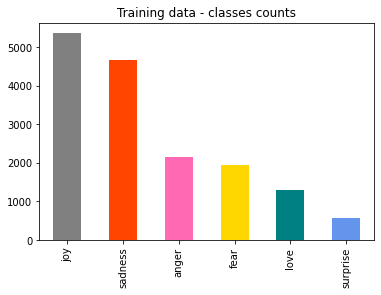

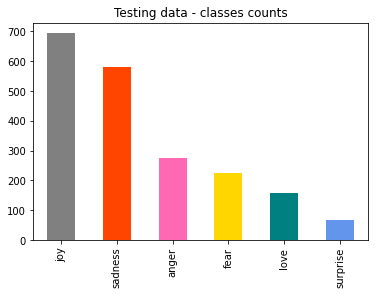

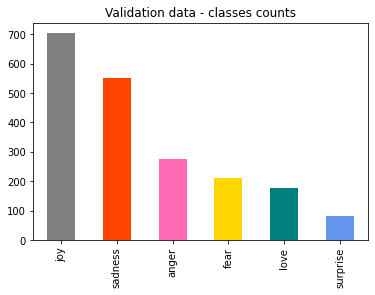

In [ ]:
# Visualize classes counts
colors = np.array(["gray", 'orangered', 'hotpink', 'gold', 'teal', 'cornflowerblue'])

df_train['Emotion'].value_counts().plot(kind='bar', color=colors)
plt.title("Training data - classes counts")
plt.show()

df_test['Emotion'].value_counts().plot(kind='bar', color=colors)
plt.title("Testing data - classes counts")
plt.show()

df_val['Emotion'].value_counts().plot(kind='bar', color=colors)
plt.title("Validation data - classes counts")
plt.show()

In [ ]:
# Encode labels
# Sudah disediakan beberapa variable, lengkapi variabel tersebut
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.fit_transform(y_test)
y_val = le.fit_transform(y_val)

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
y_val = to_categorical(y_val)

In [ ]:
# Tokenize words
tokenizer = Tokenizer()
tokenizer.fit_on_texts(pd.concat([X_train, X_test], axis=0))

sequences_train = tokenizer.texts_to_sequences(X_train)
sequences_test = tokenizer.texts_to_sequences(X_test)
sequences_val = tokenizer.texts_to_sequences(X_val)

X_train = pad_sequences(sequences_train, maxlen=256, truncating='pre')
X_test = pad_sequences(sequences_test, maxlen=256, truncating='pre')
X_val = pad_sequences(sequences_val, maxlen=256, truncating='pre')

vocabSize = len(tokenizer.index_word) + 1
print(f"Vocabulary size = {vocabSize}")

Vocabulary size = 16185


In [ ]:
#Read GloVE embeddings
path_to_glove_file = '/content/drive/MyDrive/Proa-ML/Week6/assignment/glove.6B.200d.txt'
num_tokens = vocabSize
embedding_dim = 200
hits = 0
misses = 0
embeddings_index = {}

# Read word vectors
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs
print("Found %s word vectors." % len(embeddings_index))


# Assign word vectors to our dictionary/vocabulary
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

Found 400000 word vectors.
Converted 15069 words (1115 misses)


In [ ]:
# Build neural network architecture

adam = Adam(learning_rate=0.005)
#code here

#hyperparameters
class_num = 6
dropout_rate = 0.2
recurrent_dropout_rate = 0.2
num_epoch = 30
input_length = X_train.shape[1]
num_batch = 128

# build nn

model = Sequential()
model.add(Embedding(input_dim = num_tokens,
                    output_dim = embedding_dim,
                    input_length = input_length,
                    trainable = False))
model.add(Dropout(dropout_rate))
model.add(Bidirectional(LSTM(256, dropout = dropout_rate, recurrent_dropout=recurrent_dropout_rate)))
model.add(Dense(256, activation='relu'))
model.add(Dropout(dropout_rate))
model.add(Dense(class_num, activation = 'softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer = adam,metrics = 'accuracy')


In [ ]:
#Callback
callback = EarlyStopping(
    #code here (contains at least : monitor, patience, restore_best_weights)
    monitor = 'val_loss', verbose = 1, patience = 5, restore_best_weights=False
)

In [ ]:
# Fit model
history = model.fit(
    X_train,
    y_train,
    epochs=num_epoch,
    batch_size=num_batch,
    validation_data=(X_val, y_val),
    verbose = 1,
    callbacks=callback
    )

Epoch 1/30
125/125 [==============================] - 120s 935ms/step - loss: 1.5822 - accuracy: 0.3359 - val_loss: 1.5757 - val_accuracy: 0.3355
Epoch 2/30
125/125 [==============================] - 116s 927ms/step - loss: 1.5449 - accuracy: 0.3709 - val_loss: 1.5409 - val_accuracy: 0.3605
Epoch 3/30
125/125 [==============================] - 119s 949ms/step - loss: 1.5055 - accuracy: 0.3874 - val_loss: 1.4985 - val_accuracy: 0.3885
Epoch 4/30
125/125 [==============================] - 115s 919ms/step - loss: 1.4384 - accuracy: 0.4243 - val_loss: 1.3640 - val_accuracy: 0.4595
Epoch 5/30
125/125 [==============================] - 113s 907ms/step - loss: 1.3010 - accuracy: 0.4873 - val_loss: 1.1711 - val_accuracy: 0.5665
Epoch 6/30
125/125 [==============================] - 113s 903ms/step - loss: 1.1474 - accuracy: 0.5554 - val_loss: 0.9614 - val_accuracy: 0.6375
Epoch 7/30
125/125 [==============================] - 112s 900ms/step - loss: 1.0304 - accuracy: 0.6001 - val_loss: 0.8837 -

In [ ]:
model.evaluate(X_val, y_val, verbose=1)

63/63 [==============================] - 18s 285ms/step - loss: 0.2165 - accuracy: 0.9225


[0.216510608792305, 0.9225000143051147]

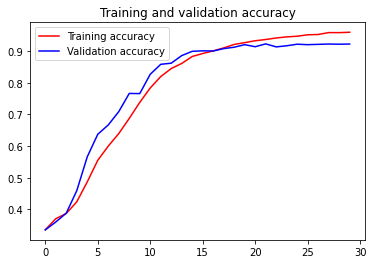

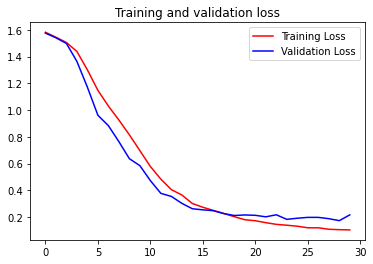

In [ ]:
# Visualize Loss & Accuracy

%matplotlib inline
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
# Classify custom sample

sentences = [
            'i am having an exam tommorow and i feel very anxious',
             '\'
            ]
for sentence in sentences:
    print(sentence)
    sentence = clean(sentence)
    sentence = tokenizer.texts_to_sequences([sentence])
    sentence = pad_sequences(sentence, maxlen=256, truncating='pre')
    result = le.inverse_transform(np.argmax(model.predict(sentence), axis=-1))[0]
    proba =  np.max(model.predict(sentence))
    print(f"{result} : {proba}\n")

i am having an exam tommorow and i feel very anxious
fear : 0.9999927282333374

i would like to go dinner with you tonight
anger : 0.5354531407356262



In [ ]:
import pickle
with open('tokenizer.pickle', 'wb') as f:
    pickle.dump(tokenizer, f)
    
with open('labelEncoder.pickle', 'wb') as f:
    pickle.dump(le, f)
    
    
model.save('Emotion Recognition.h5')